# PBL-2 Detection of SQL Injection Attacks using AI
## Team: Saahil Shaikh, Sanjana Sharma, Sachit Desai, Sehaj Saluja

## 1. Importing Required Libraries

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm.auto import tqdm

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import chardet
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
data=pd.read_csv('https://raw.githubusercontent.com/sehajsaluja17/ThreatBusters/main/SQLI/Modified_SQL_Dataset.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/sehajsaluja17/ThreatBusters/main/SQLI/SQLi_excel_genius.csv', encoding='Windows-1252')
df3 = pd.read_csv('https://raw.githubusercontent.com/sehajsaluja17/ThreatBusters/main/SQLI/sqliv2_excel_genius.csv', encoding = 'Windows-1252')
df4 = pd.read_csv('https://raw.githubusercontent.com/sehajsaluja17/ThreatBusters/main/SQLI/SQLiV3.csv', encoding='utf-8')
df5=pd.read_csv('https://raw.githubusercontent.com/sehajsaluja17/ThreatBusters/main/SQLI/SQLi4.csv',encoding='utf-8')

<ipython-input-38-9bc1b7c23648>:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df4 = pd.read_csv('https://raw.githubusercontent.com/sehajsaluja17/ThreatBusters/main/SQLI/SQLiV3.csv', encoding='utf-8')


In [39]:
print(data.columns)
print(df2.columns)
print(df3.columns)
print(df4.columns)
print(df5.columns)
df4.rename(columns = {'Query ':'Query'}, inplace = True)
print(df4.columns)


Index(['Query', 'Label'], dtype='object')
Index(['Query', 'Label'], dtype='object')
Index(['Query', 'Label'], dtype='object')
Index(['Query ', 'Label'], dtype='object')
Index(['Query', 'Label'], dtype='object')
Index(['Query', 'Label'], dtype='object')


In [40]:
data.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)
df3.reset_index(drop=True, inplace=True)
df4.reset_index(drop=True, inplace=True)
df5.reset_index(drop=True, inplace=True)

#Convert dataframes to similar encoding- utf-8
data.to_csv('Modified_SQL_Dataset_utf8.csv', encoding='utf-8', index=False)
df2.to_csv('SQLi_excel_genius_utf8.csv', encoding='utf-8', index=False)
df3.to_csv('sqliv2_excel_genius_utf8.csv', encoding='utf-8', index=False)

# Merge datasets
merged_data = pd.concat([data,df2, df3,df4,df5], ignore_index=True)

In [41]:
merged_data.shape

(1121655, 2)

In [42]:
merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121655 entries, 0 to 1121654
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Query   83720 non-null  object 
 1   Label   83726 non-null  float64
dtypes: float64(1), object(1)
memory usage: 17.1+ MB


In [43]:
merged_data.describe()


,Label
count,83726.000000
mean,0.300456
std,0.458459
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [44]:
num_unique_values = merged_data.nunique()
print("Number of unique values for each column:")
print(num_unique_values)


Number of unique values for each column:
Query    55404
Label        2
dtype: int64


## 2. Data Issues


In [45]:
merged_data.isnull().sum()

Query    1037935
Label    1037929
dtype: int64

In [46]:
# Handling Duplicate values
print(merged_data.duplicated().sum())
merged_data_no_duplicates = merged_data.drop_duplicates()
print(merged_data_no_duplicates.shape)


1066226
(55429, 2)


In [47]:
#Checking for null values
merged_data_no_duplicates.isnull().sum()

Query     3
Label    24
dtype: int64

In [48]:
unlabelled_data = merged_data_no_duplicates[merged_data_no_duplicates.isnull().any(axis=1)]
merged_data_no_duplicates = merged_data_no_duplicates.dropna()


In [49]:
merged_data_no_duplicates.isnull().sum()

Query    0
Label    0
dtype: int64

Thus all null values were removed from the data


## EDA

<ipython-input-50-8f36c7c00347>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_data_no_duplicates, x='Label', palette='Set2')


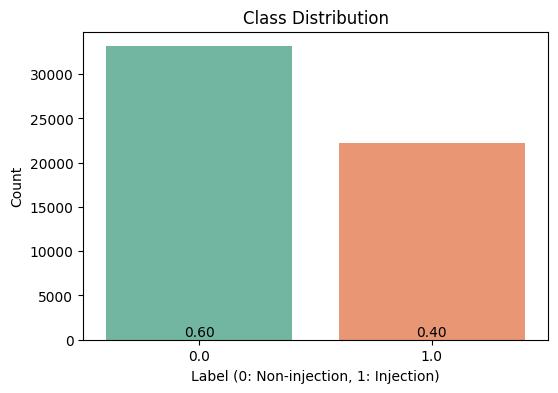

In [50]:
#class distribution

class_distribution = merged_data_no_duplicates['Label'].value_counts(normalize=True)
plt.figure(figsize=(6, 4))
sns.countplot(data=merged_data_no_duplicates, x='Label', palette='Set2')
plt.title('Class Distribution')
plt.xlabel('Label (0: Non-injection, 1: Injection)')
plt.ylabel('Count')

# Displaying ratio of labels
for i, count in enumerate(class_distribution):
    plt.text(i, count, f'{count:.2f}', ha='center', va='bottom')

plt.show()

#found that ratio is 60:40

It is observed that there is a class imbalance of ratio 60:40 where we have more Non injection queries than injection queries. To balance this dataset Data augmentation can be applied.

Further to provide a comparative analysis, the results without handling the imbalanced data and after handling the imbalanced data will be observed.

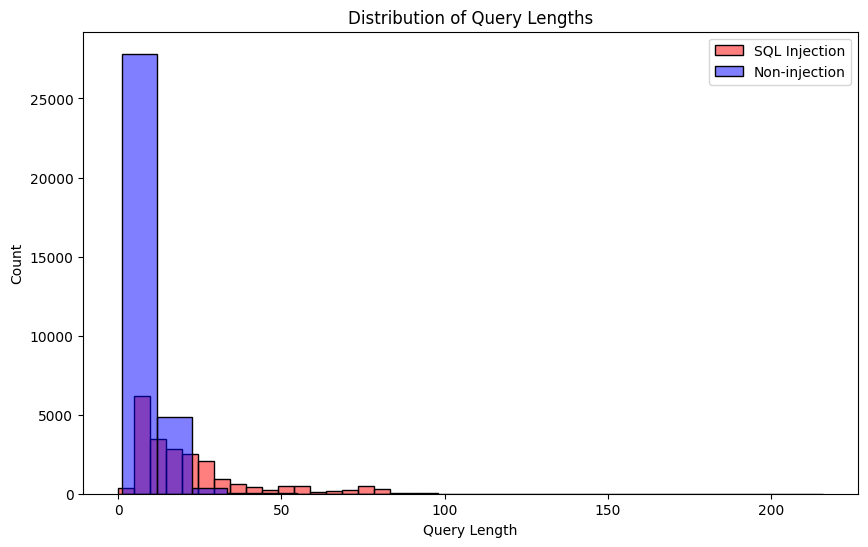

In [51]:
# Separate SQL injection and non-injection queries
sql_injection_lengths = merged_data_no_duplicates[merged_data_no_duplicates['Label'] == 1]['Query'].apply(lambda x: len(x.split()))
non_injection_lengths = merged_data_no_duplicates[merged_data_no_duplicates['Label'] == 0]['Query'].apply(lambda x: len(x.split()))

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(sql_injection_lengths, bins=20, color='red', alpha=0.5, label='SQL Injection')
sns.histplot(non_injection_lengths, bins=20, color='blue', alpha=0.5, label='Non-injection')
plt.title('Distribution of Query Lengths')
plt.xlabel('Query Length')
plt.ylabel('Count')
plt.legend()
plt.show()


SQl-Injection queries are seen to be shorter in length as compared to non- injection queries. Will have to check the presence of outliers ahead

<ipython-input-52-e8350f036c36>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_df_sql.head(20), x='Word', y='Frequency', palette='Reds_r')


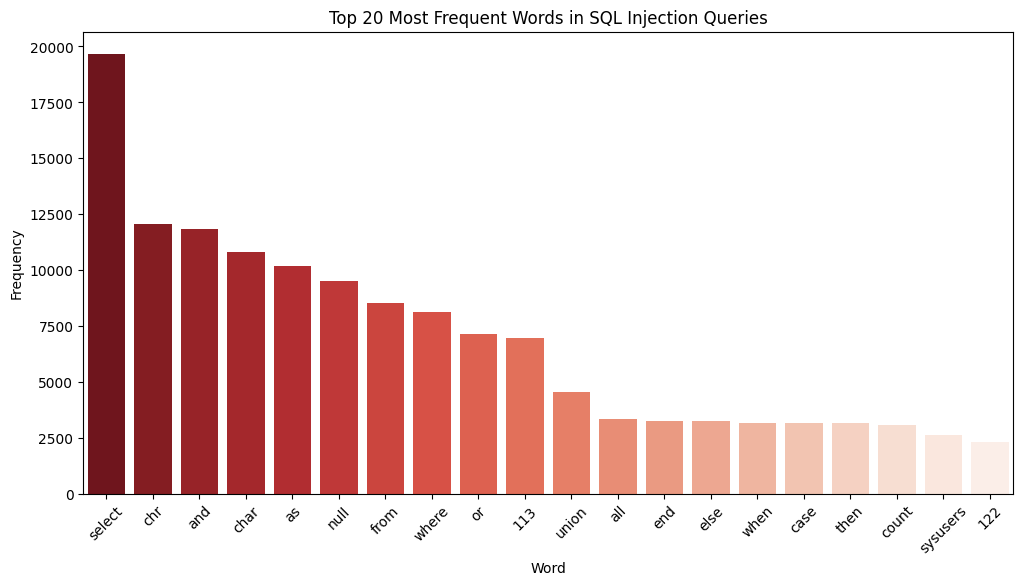

<ipython-input-52-e8350f036c36>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=word_df_non_sql.head(20), x='Word', y='Frequency', palette='Blues_r')


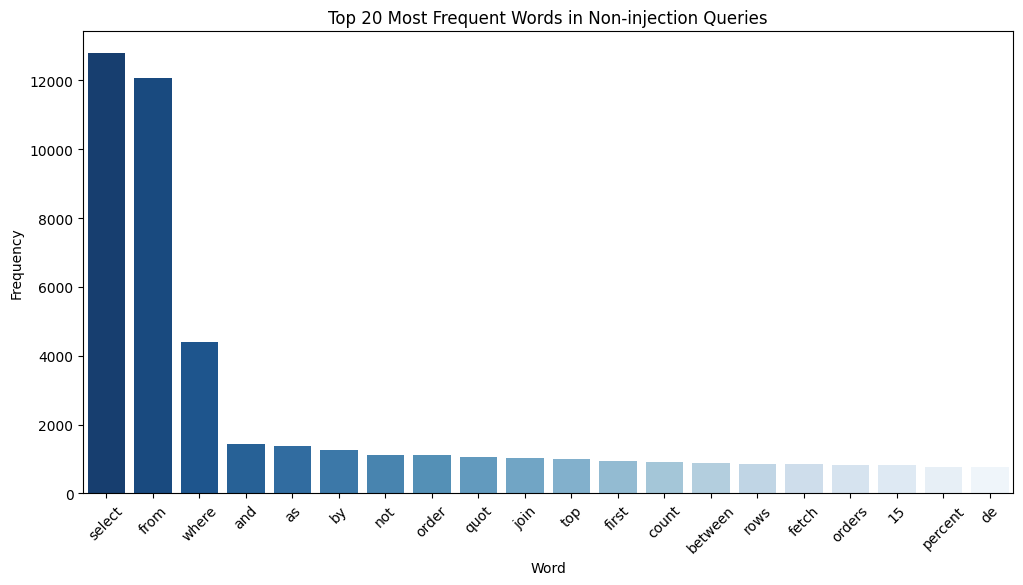

In [52]:
# Separate SQL injection and non-injection queries
sql_injection_queries = merged_data_no_duplicates[merged_data_no_duplicates['Label'] == 1]['Query']
non_injection_queries = merged_data_no_duplicates[merged_data_no_duplicates['Label'] == 0]['Query']

# Word Frequency Analysis for SQL injection queries
vectorizer_sql = CountVectorizer()
X_sql = vectorizer_sql.fit_transform(sql_injection_queries)
word_frequencies_sql = np.array(X_sql.sum(axis=0)).flatten()
word_df_sql = pd.DataFrame({'Word': vectorizer_sql.get_feature_names_out(), 'Frequency': word_frequencies_sql})
word_df_sql = word_df_sql.sort_values(by='Frequency', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=word_df_sql.head(20), x='Word', y='Frequency', palette='Reds_r')
plt.title('Top 20 Most Frequent Words in SQL Injection Queries')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Word Frequency Analysis for non-injection queries
vectorizer_non_sql = CountVectorizer()
X_non_sql = vectorizer_non_sql.fit_transform(non_injection_queries)
word_frequencies_non_sql = np.array(X_non_sql.sum(axis=0)).flatten()
word_df_non_sql = pd.DataFrame({'Word': vectorizer_non_sql.get_feature_names_out(), 'Frequency': word_frequencies_non_sql})
word_df_non_sql = word_df_non_sql.sort_values(by='Frequency', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(data=word_df_non_sql.head(20), x='Word', y='Frequency', palette='Blues_r')
plt.title('Top 20 Most Frequent Words in Non-injection Queries')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


Ignoring the fact that select is the most common keyword in SQL queries and is almost necessary to write most queries. A striking difference between the words used in Injection Queries and non injection queries.

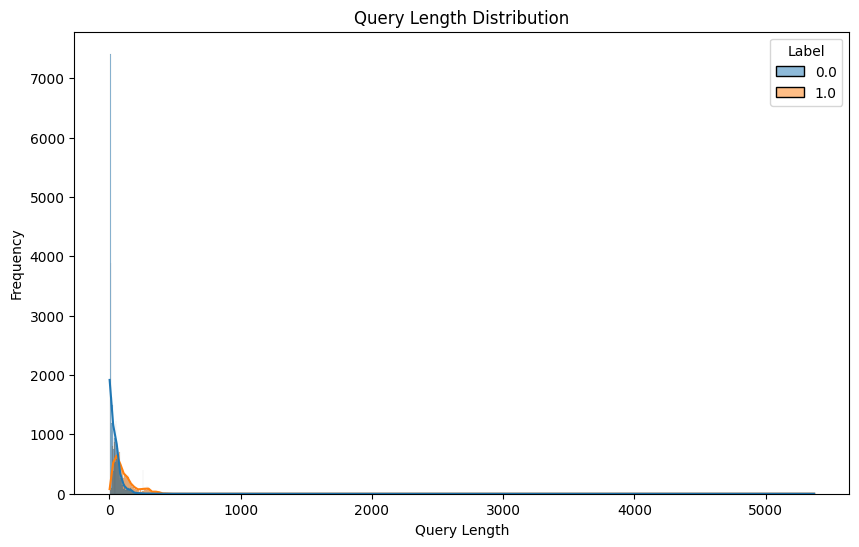

In [53]:
#query length distribution
merged_data_no_duplicates = merged_data_no_duplicates.dropna(subset=['Query'])
merged_data_no_duplicates['Query_Length'] = merged_data_no_duplicates['Query'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=merged_data_no_duplicates, x='Query_Length', hue='Label', kde=True)
plt.title('Query Length Distribution')
plt.xlabel('Query Length')
plt.ylabel('Frequency')
plt.show()

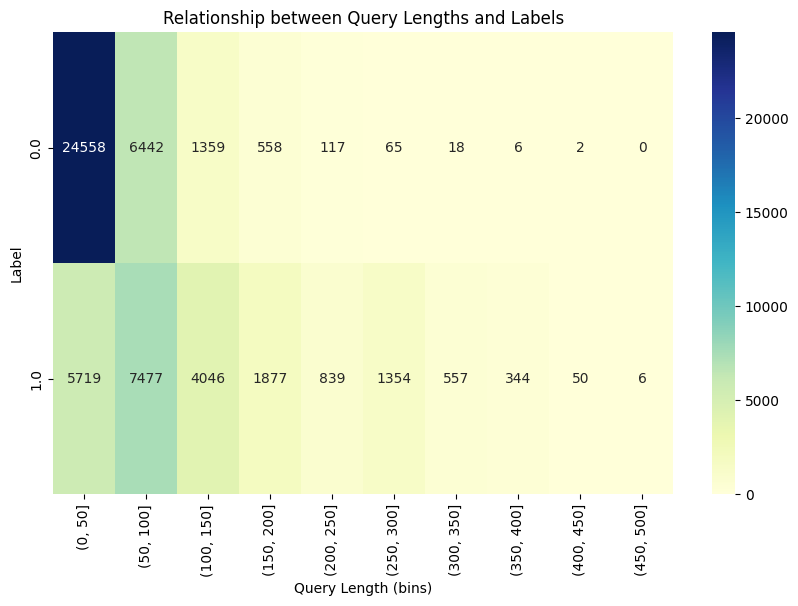

In [54]:
merged_data_no_duplicates = merged_data_no_duplicates.dropna(subset=['Query'])

# Define the bin edges for query lengths
bin_edges = list(range(0, 540, 50))  # Creating bins of width 50 up to maximum length of 538

# Create a heatmap
plt.figure(figsize=(10, 6))
heatmap_data = merged_data_no_duplicates.pivot_table(index='Label', columns=pd.cut(merged_data_no_duplicates['Query_Length'], bins=bin_edges), aggfunc='size', fill_value=0)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Relationship between Query Lengths and Labels')
plt.xlabel('Query Length (bins)')
plt.ylabel('Label')
plt.show()

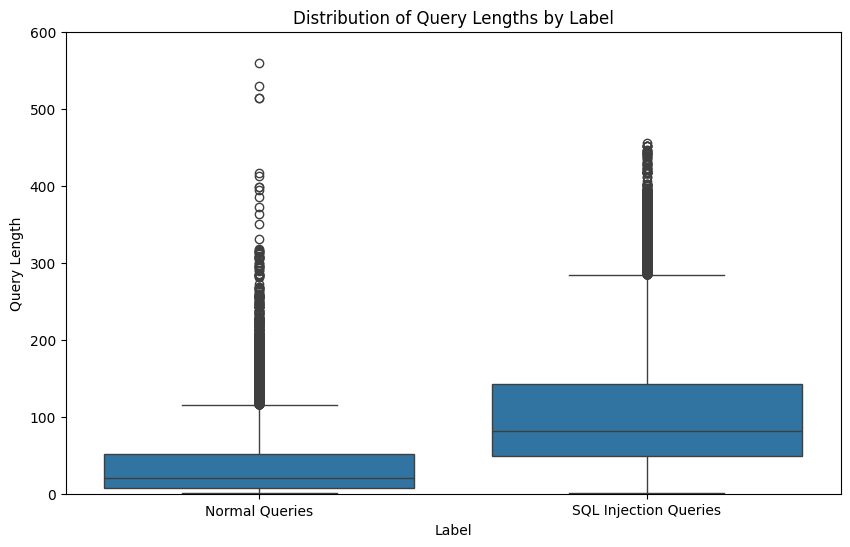

In [55]:
merged_data_no_duplicates = merged_data_no_duplicates.dropna(subset=['Query'])

# Create a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Label', y='Query_Length', data=merged_data_no_duplicates)
plt.title('Distribution of Query Lengths by Label')
plt.xlabel('Label')
plt.ylabel('Query Length')
plt.xticks([0, 1], ['Normal Queries', 'SQL Injection Queries'])
plt.ylim(0, 600)  # Limiting y-axis to 600 characters
plt.show()

The presence of outliers in both normal and injection is massive. Numeric data in the query feature were observed and on further cleaning of the data can be made better. Also cannot ignore the fact that they can be genuine outliers and removing them might affect model performance

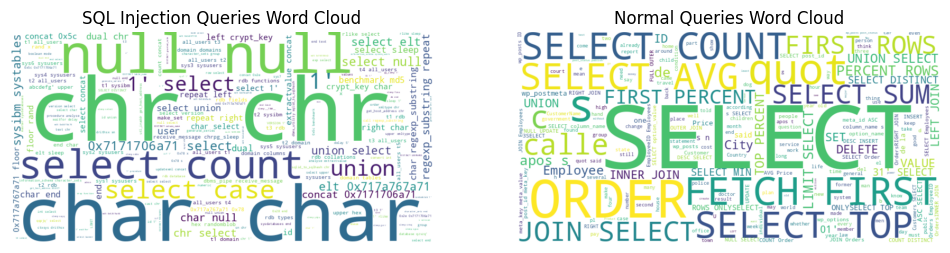

In [56]:
merged_data_no_duplicates = merged_data_no_duplicates.dropna(subset=['Query'])

# Separate SQL injection queries and normal queries
sql_injection_queries = merged_data_no_duplicates[merged_data_no_duplicates['Label'] == 1]['Query']
normal_queries = merged_data_no_duplicates[merged_data_no_duplicates['Label'] == 0]['Query']

# Generate word cloud for SQL injection queries
sql_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(sql_injection_queries))

# Generate word cloud for normal queries
normal_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(normal_queries))

# Plot word clouds
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(sql_wordcloud, interpolation='bilinear')
plt.title('SQL Injection Queries Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(normal_wordcloud, interpolation='bilinear')
plt.title('Normal Queries Word Cloud')
plt.axis('off')

plt.show()

## 3. Data Preprocessing


In [57]:
# adding a new field: length which will contain length of query
# Add a new column 'Query_Length' containing the length of each query
merged_data_no_duplicates['Query_Length'] = merged_data_no_duplicates['Query'].apply(len)

# Display the DataFrame with the new 'Query_Length' column
merged_data_no_duplicates.head()

,Query,Label,Query_Length
0,""" or pg_sleep ( __TIME__ ) --",1.0,33
1,create user name identified by pass123 tempora...,1.0,90
2,AND 1 = utl_inaddr.get_host_address ( ...,1.0,218
3,select * from users where id = '1' or @ @1 ...,1.0,90
4,"select * from users where id = 1 or 1#"" ( ...",1.0,85


In [58]:
# removing punctuation marks - ['!', "," ,"\'" ,";" ,"\"", ".", "-" ,"?","[","]",")","("].
import re

punctuation_to_drop = ['!', ',', '\'', '\"', '.', '?', '[', ']', ')', '(']

# Function to remove specific punctuation from a string
def remove_punctuation(text):

    # regular expression pattern to match the specified punctuation marks
    punctuation_pattern = '[' + re.escape(''.join(punctuation_to_drop)) + ']'

    # Use the sub() function to replace the specified punctuation with an empty string
    clean_text = re.sub(punctuation_pattern, '', text)
    return clean_text

# Apply the function to remove specific punctuation from the 'Query' column
merged_data_no_duplicates['Query'] = merged_data_no_duplicates['Query'].apply(remove_punctuation)

merged_data_no_duplicates.head()

,Query,Label,Query_Length
0,or pg_sleep __TIME__ --,1.0,33
1,create user name identified by pass123 tempora...,1.0,90
2,AND 1 = utl_inaddrget_host_address ...,1.0,218
3,select * from users where id = 1 or @ @1 =...,1.0,90
4,select * from users where id = 1 or 1# ...,1.0,85


In [59]:
# counting keywords
sql_keywords = ['SELECT', 'UPDATE', 'INSERT', 'DELETE', 'FROM', 'WHERE', 'AND', 'OR', 'ORDER BY', 'GROUP BY', 'HAVING', 'JOIN', 'INNER JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'UNION', 'ALL']

# Function to count sql keywords in a query
def count_sql_keywords(query):
    total_count = 0
    for keyword in sql_keywords:
        total_count += query.upper().count(keyword)
    return total_count

# Apply the function to count keywords in each query
merged_data_no_duplicates['Keyword_Counts'] = merged_data_no_duplicates['Query'].apply(count_sql_keywords)
merged_data_no_duplicates.head()

,Query,Label,Query_Length,Keyword_Counts
0,or pg_sleep __TIME__ --,1.0,33,1
1,create user name identified by pass123 tempora...,1.0,90,1
2,AND 1 = utl_inaddrget_host_address ...,1.0,218,8
3,select * from users where id = 1 or @ @1 =...,1.0,90,6
4,select * from users where id = 1 or 1# ...,1.0,85,6


In [60]:

# Cleaning text
def convert_to_lower(text):
    return text.lower()

def remove_numbers(text):
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl=" ", string=text)
    return without_number

def lemmatizing(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    for i in range(len(tokens)):
        lemma_word = lemmatizer.lemmatize(tokens[i])
        tokens[i] = lemma_word
    return " ".join(tokens)

def remove_stopwords(text):
    removed = []
    # Define custom stopwords list excluding SQL keywords
    custom_stopwords = [word.lower() for word in stopwords.words("english") if word.lower() not in sql_keywords]
    tokens = word_tokenize(text)
    for token in tokens:
        if token.lower() not in custom_stopwords:
            removed.append(token)
    return " ".join(removed)

def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc


In [61]:
merged_data_no_duplicates['Query'] = merged_data_no_duplicates['Query'].apply(lambda x: convert_to_lower(x))
merged_data_no_duplicates['Query'] = merged_data_no_duplicates['Query'].apply(lambda x: remove_numbers(x))
merged_data_no_duplicates['Query'] = merged_data_no_duplicates['Query'].apply(lambda x: remove_stopwords(x))
merged_data_no_duplicates['Query'] = merged_data_no_duplicates['Query'].apply(lambda x: remove_extra_white_spaces(x))
merged_data_no_duplicates['Query'] = merged_data_no_duplicates['Query'].apply(lambda x: lemmatizing(x))

In [62]:
merged_data_no_duplicates.head()

,Query,Label,Query_Length,Keyword_Counts
0,pg_sleep __time__ --,1.0,33,1
1,create user name identified pas temporary tabl...,1.0,90,1
2,= utl_inaddrget_host_address select distinct t...,1.0,218,8
3,select * user id = @ @ = union select version --,1.0,90,6
4,select * user id = # union select version --,1.0,85,6


In [63]:
# Text Vectorization without balancing
tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(2,3), lowercase=True, strip_accents='unicode', min_df=1)

# Fitting and transforming 'Query' column to compute TF-IDF scores
tfidf_matrix = tfidf_vect.fit_transform(merged_data_no_duplicates['Query'])

# Converting the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vect.get_feature_names_out())

# Display the TF-IDF DataFrame
tfidf_df.head()

,_bg _file,_bg _file _sync,_bg _image,_bg _image _sync,_bg _non,_bg _non _library,_db_updated limit,_file _sync,_file _sync _batch,_filter _filter,...,주나빠요하하 hip,주나빠요하하 hip xqse,추 va,추 va akunws,트리거 vsrxv,트리거 vsrxv dfodxwh,트리거 트리거,트리거 트리거 vsrxv,홍길동 yoda,홍길동 yoda master
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.1 Data Augmentation

In [64]:
# !pip install transformers
# !pip install nlpaug

In [65]:
# import nlpaug.augmenter.word.context_word_embs as aug

In [66]:
# augmenter = aug.ContextualWordEmbsAug(model_path='bert-base-uncased', action = 'insert')


In [67]:
class_distribution = merged_data_no_duplicates['Label'].value_counts()

# Print the class distribution
print("Class Distribution:")
print(class_distribution)
# 1 is the underrepresented class which are the Sql injection queries
#10,865 is the difference between the samples

Class Distribution:
Label
0.0    33134
1.0    22269
Name: count, dtype: int64


In [68]:
# def augmentMyData(df, augmenter, repetitions=1, samples=200):
#     augmented_texts = []
#     # select only the minority class samples
#     inject_df = df[df['Label'] == 1].reset_index(drop=True) # removes unecessary index column
#     for i in tqdm(np.random.randint(0, len(inject_df), samples)):
#         # generating 'n_samples' augmented texts
#         for _ in range(repetitions):
#             augmented_text = augmenter.augment(inject_df['Query'].iloc[i])
#             augmented_texts.append(augmented_text)

#     data = {
#         'Label': 1,
#         'Query': augmented_texts
#     }
#     aug_df = pd.DataFrame(data)
#     df = shuffle(df.append(aug_df).reset_index(drop=True))
#     return df

In [69]:
# new_df = merged_data_no_duplicates.drop(labels=['Query_Length','Keyword_Counts'], axis= 1)

In [70]:
# new_df.head()

,Query,Label
0,pg_sleep __time__ --,1.0
1,create user name identified pas temporary tabl...,1.0
2,= utl_inaddrget_host_address select distinct t...,1.0
3,select * user id = @ @ = union select version --,1.0
4,select * user id = # union select version --,1.0


In [71]:
# merged_data_no_duplicates.columns

Index(['Query', 'Label', 'Query_Length', 'Keyword_Counts'], dtype='object')

In [ ]:
# aug_df = augmentMyData(new_df,augmenter,samples=10865)

  0%|          | 0/10865 [00:00<?, ?it/s]